This notebook solves SAT for https://github.com/VeriFIT/smt-bench/blob/master/formulae/slog/slog_stranger_2959_sink.smt2 manually using algos from Noodler.

In [1]:
import noodler

In [2]:
filename = "../benchmarks/slog/slog_stranger_2959_sink.smt2"
parser = noodler.parser.SmtlibParserHackAbc(filename)
query = parser.parse_query()

Here is the list of equations and graph showing dependencies between variables

In [3]:
graph = '<img src="Dependency-graph.png" alt="Drawing" style="width: 400px;"/>'
eq_str = "<br />".join([e.__str__() for e in query.equations])

noodler.utils.display_inline(eq_str, graph, per_row=2)

The function `is_sat` basically implements the following recursive algorithm. It iterates the equations in the backward direction and creates unified noodles. If it finds a viable noodle for each equation (level), it returns `True` (SAT).
```python
def _is_sat_rec(level: int, constraints):
    if level < 0:
        return True
    # We use switched equations. We need the form:
    # y₁y₂y₃ = x
    cur_query = AutSingleSEQuery(self.query.equations[level].switched,
                                 constraints)

    noodler = SimpleNoodler(cur_query)
    noodles: Sequence[SingleSEQuery] = noodler.noodlify()
    
    # If no unified noodle exists, we are done with unsat as result
    for noodle in noodles:
        cur_constraints: AutConstraints = constraints.copy()
        cur_constraints.update(noodle.constraints)

        if _is_sat_rec(level - 1, cur_constraints):
            return True

    return False
```

The verbose output shows the equations and their index (level), sizes of automata for constraints at the beginning, and at each recursive call it prints the (total) number of noodles at each level (all used, processing, and to be processed).

In [4]:
machine = noodler.noodler.StraightlineNoodleMachine(query)
machine.is_sat(verbose=True)

====EQUATIONS====
0: ['x_8'] = ['literal_7', 'sigmaStar_2']
1: ['x_10'] = ['x_8', 'literal_9']
2: ['x_12'] = ['x_10', 'sigmaStar_1']
3: ['x_15'] = ['x_12', 'literal_13']
4: ['x_17'] = ['x_15', 'sigmaStar_6']
5: ['x_21'] = ['x_17', 'literal_19']
6: ['x_24'] = ['x_21', 'literal_18']
7: ['x_25'] = ['x_24', 'literal_23']
8: ['x_26'] = ['literal_22', 'x_25']
9: ['x_29'] = ['x_26', 'literal_27']
10: ['x_31'] = ['x_29', 'x_25']
11: ['x_33'] = ['literal_30', 'x_25']
12: ['x_34'] = ['x_31', 'literal_32']
13: ['x_36'] = ['x_33', 'literal_35']
14: ['x_37'] = ['x_34', 'x_25']
15: ['x_39'] = ['x_37', 'x_36']
16: ['x_41'] = ['x_39', 'literal_40']
====Constraints` sizes====
x_41: 9 states, 1 final
literal_7: 98 states, 1 final
literal_9: 24 states, 1 final
literal_13: 41 states, 1 final
literal_19: 35 states, 1 final
literal_18: 13 states, 1 final
literal_23: 78 states, 1 final
literal_22: 100 states, 1 final
literal_27: 16 states, 1 final
literal_30: 14 states, 1 final
literal_32: 10 states, 1 final

True

## De-noodlified graph-based algowithm

In [5]:
from IPython.display import HTML
HTML(graph)

In [6]:
from noodler import SimpleNoodler, AutSingleSEQuery, noodlify, StraightlineNoodleMachine
from noodler.algos import eps_preserving_product, split_segment_aut
from noodler.utils import show_automata
import awalipy

The function `propagate_constraints` makes a _forward-direction_ (fwd) pass through the graph and propagates the constraints in the fwd manner. That means, uses all equations in the original form L=R and runs the basic (for 1 equation) noodlifying algo on equations 0 to 16. The next cell shows the sizes of constraint automata for all variables before (`init`) and after (`fwd`) the call to `propagate_constraints`.

In [7]:
#%%timeit
init_constr = query.aut_constraints.copy()
# Use NoodleMachine for forward constraints
nm = StraightlineNoodleMachine(query)
forward_constr = init_constr.copy()
nm.propagate_constraints(forward_constr)

In [8]:
for var in init_constr:
    print(f"{var}: init: {init_constr[var].num_states()}; fwd: {forward_constr[var].num_states()}")

x_41: init: 9; fwd: 2390
literal_7: init: 98; fwd: 98
literal_9: init: 24; fwd: 24
literal_13: init: 41; fwd: 41
literal_19: init: 35; fwd: 35
literal_18: init: 13; fwd: 13
literal_23: init: 78; fwd: 78
literal_22: init: 100; fwd: 100
literal_27: init: 16; fwd: 16
literal_30: init: 14; fwd: 14
literal_32: init: 10; fwd: 10
literal_35: init: 50; fwd: 50
literal_40: init: 16; fwd: 16
x_10: init: 1; fwd: 122
x_33: init: 1; fwd: 300
sigmaStar_2: init: 1; fwd: 1
sigmaStar_1: init: 1; fwd: 1
sigmaStar_6: init: 1; fwd: 1
x_24: init: 1; fwd: 210
x_15: init: 1; fwd: 163
x_12: init: 1; fwd: 123
x_17: init: 1; fwd: 164
x_21: init: 1; fwd: 198
x_37: init: 1; fwd: 982
x_25: init: 1; fwd: 287
x_31: init: 1; fwd: 687
x_36: init: 1; fwd: 349
x_34: init: 1; fwd: 696
x_39: init: 1; fwd: 1330
x_29: init: 1; fwd: 401
x_8: init: 1; fwd: 99
x_26: init: 1; fwd: 386


Now let's manually solve the first equation and make the constraint for `x_39` more precise using the backward traversal — we treat the equations like if they are swapped, e.g. R=L.

`AutSingleSEQuery` is basically a tuple of an equation and constraints.

In [9]:
current_constr = init_constr.copy()

# Query for the last equation
q16 = AutSingleSEQuery(query.equations[16], current_constr)

# automaton for x41
a41 = q16.automata_for_side("left")[0]
assert a41 == init_constr["x_41"]

# Get segment automaton (with ε-transitions) for right side
right16 = q16.seg_aut("right")
# Build ε-preserving product of left and right side
product = eps_preserving_product(right16, a41, history=True)

# We should have just one noodle here
assert len(noodlify(product)) == 1

# Build new constraints
segments = split_segment_aut(product)
new_constr = dict(zip(q16.eq.right, segments))

We just learnt new constraints for `x_39`. Let's see it.

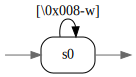

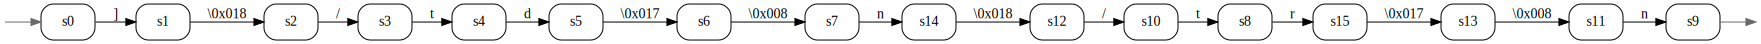

In [10]:
init_constr["x_39"].display()
init_constr["literal_40"].display()

We can also use `show_automata` from `noodler.utils` to display constraints conveniently.

In [11]:
show_automata(new_constr)

As all was precise (we had just one noodle), we can update our hard constraints.

In [12]:
def update_constraints(base_constraints, new_constraints):
    for var, aut in new_constraints.items():
        base_constraints[var] = base_constraints[var].product(aut).trim()

In [13]:
update_constraints(current_constr, new_constr)

We define a new function that processes one equation and creates the segments for the right-hand side as a product with the left side of the equation. We use this later when traversing the system-graph with the de-noodlified approach.

In [14]:
def segment_product(equation, constraints):
    """
    Returns a segment automaton for the right-hand side of
    `equation` intersected with left-hand side of `equation`.
    """
    q = AutSingleSEQuery(equation, constraints)
    var_aut = q.automata_for_side("left")[0]
    # Get segment automaton (with ε-transitions) for right side
    right = q.seg_aut("right")
    return eps_preserving_product(right, var_aut)

In [15]:
def restrict_right_side(equation, constraints):
    """
    Returns new constraints in the form of segments (not noodles).
    This is an overapproximation.
    """
    product = segment_product(equation, constraints)
    segments = split_segment_aut(product)
    segments = [aut.minimal_automaton().trim() for aut in segments]
    return dict(zip(equation.right, segments))

In [16]:
product = segment_product(query.equations[15], current_constr)
new_constr = restrict_right_side(query.equations[15], current_constr)
print(new_constr.keys())

dict_keys(['x_37', 'x_36'])


Now we have 9 noodles. Let's try avoiding iterating over them.

In [17]:
len(noodlify(product))

9

This will be an overapproximation as we will remember only segments, not all noodles. Unfortunatelly, we forget way too much!

In [18]:
new_constr = restrict_right_side(query.equations[15], current_constr)
show_automata(new_constr)
segment_constr = current_constr.copy()
update_constraints(segment_constr, new_constr)

Let's now go over the first path from 39 to 25, this are equations 13, and 11.

In [19]:
new_constr = restrict_right_side(query.equations[13], segment_constr)
show_automata(new_constr)
update_constraints(segment_constr, new_constr)
new_constr = restrict_right_side(query.equations[11], segment_constr)
show_automata(new_constr)
update_constraints(segment_constr, new_constr)
new_constr = restrict_right_side(query.equations[14], segment_constr)
show_automata(new_constr)
update_constraints(segment_constr, new_constr)
new_constr = restrict_right_side(query.equations[12], segment_constr)
show_automata(new_constr)
update_constraints(segment_constr, new_constr)
new_constr = restrict_right_side(query.equations[10], segment_constr)
show_automata(new_constr)
update_constraints(segment_constr, new_constr)
new_constr = restrict_right_side(query.equations[9], segment_constr)
show_automata(new_constr)
update_constraints(segment_constr, new_constr)
new_constr = restrict_right_side(query.equations[8], segment_constr)
show_automata(new_constr)
update_constraints(segment_constr, new_constr)

OK, this does not work as the segmentation tends to forget way too much. Maybe we can do better by doing the quick checks later? Like make noodles for `x_39` and segments later.

In [20]:
noodle_constraints = []
for noodle in noodles15:
    x37_c_n, x36_c_n = split_segment_aut(noodle)
    constraints = current_constr.copy()
    constraints["x_37"] = constraints["x_37"].product(x37_c_n).minimal_automaton().trim()
    constraints["x_36"] = constraints["x_36"].product(x36_c_n).minimal_automaton().trim()
    noodle_constraints.append(constraints)

NameError: name 'noodles15' is not defined

In [21]:
def x36_to_x25(constr):
    q13 = AutSingleSEQuery(query.equations[13].switched,
                           constr)
    n13 = SimpleNoodler(q13)
    noodles13 = n13.noodlify()
    assert len(noodles13) == 1
    constr.update(noodles13[0].constraints)
    q11 = AutSingleSEQuery(query.equations[11].switched,
                           constr)
    n11 = SimpleNoodler(q11)
    noodles11 = n11.noodlify()
    assert len(noodles11) == 1
    constr.update(noodles11[0].constraints)

Let's try to propagate the new constraint for `x_25` in the fwd direction to the rest of the noodle for `x_37` and see if it fits.

In [22]:
def propagate_fwd(equations, constr):
    new_constr = {}
    c = constr.copy()
    for eq in equations:
        query = AutSingleSEQuery(eq, c)
        assert len(eq.left) == 1
        left_var = eq.left[0]
        current_constr = c[left_var]
        right_auts = query.proper_aut("right", minimize=False)
        new_constr[left_var] = awalipy.product(current_constr, right_auts).trim()
        c.update(new_constr)
    return new_constr

In [26]:
for ni in range(len(noodles15)):
    x36_to_x25(noodle_constraints[ni])
    eq25_to_37_ids = [8,9,10,12,14]
    eq25_to_37 = [query.equations[i] for i in eq25_to_37_ids]
    fwd = propagate_fwd(eq25_to_37, noodle_constraints[ni])
    if fwd["x_37"].num_useful_states() == 0:
        print("Killed the noodle by fwd")
    else:
        print("Check the noodle")
        # TODO Mayve only update x37
        # noodle_constraints[ni].update(fwd)

Killed the noodle by fwd
Killed the noodle by fwd
Killed the noodle by fwd
Killed the noodle by fwd
Killed the noodle by fwd
Killed the noodle by fwd
Killed the noodle by fwd
Killed the noodle by fwd
Check the noodle


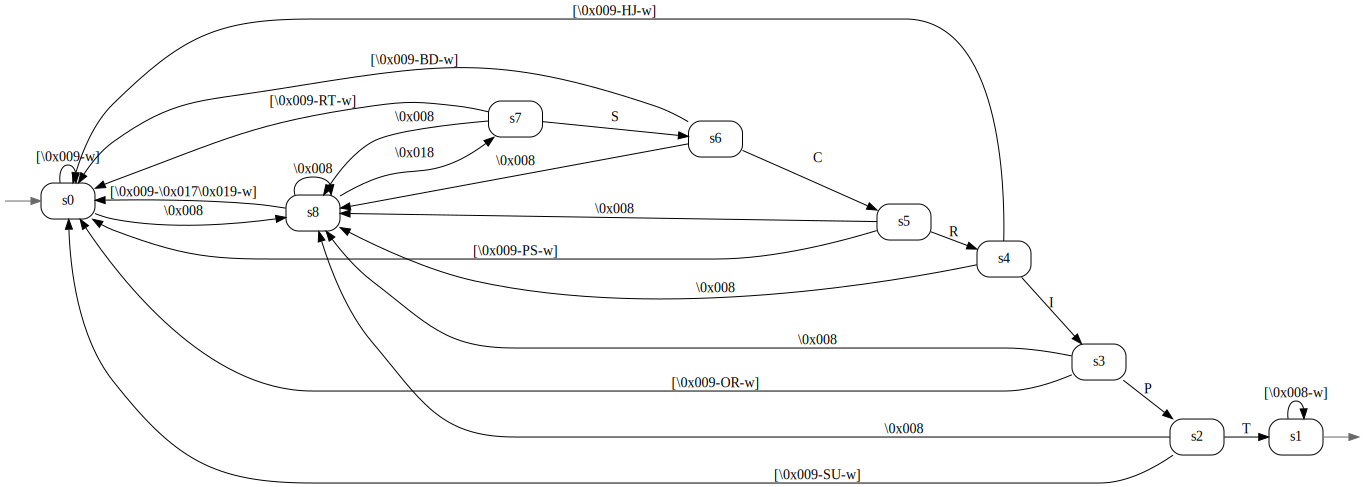

In [27]:
noodle_constraints[8]["x_37"].display()

In [28]:
c14 = noodle_constraints[8]

In [29]:
q14 = AutSingleSEQuery(query.equations[14].switched,
                           c14)
n14 = SimpleNoodler(q14)
noodles14 = n14.noodlify()

In [30]:
len(noodles14)

9

In [31]:
eq0_to_25 = [query.equations[i] for i in range(8)]
fwd_25 = propagate_fwd(eq0_to_25, noodle_constraints[ni])["x_25"]
fwd_25.num_states()

287

This attempts to go to 25 first via x37 and use the whole segment(s) corresponding to various possibilities to get to x25 and see if it can kill some noodles from x39.

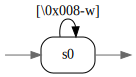

nudle
18


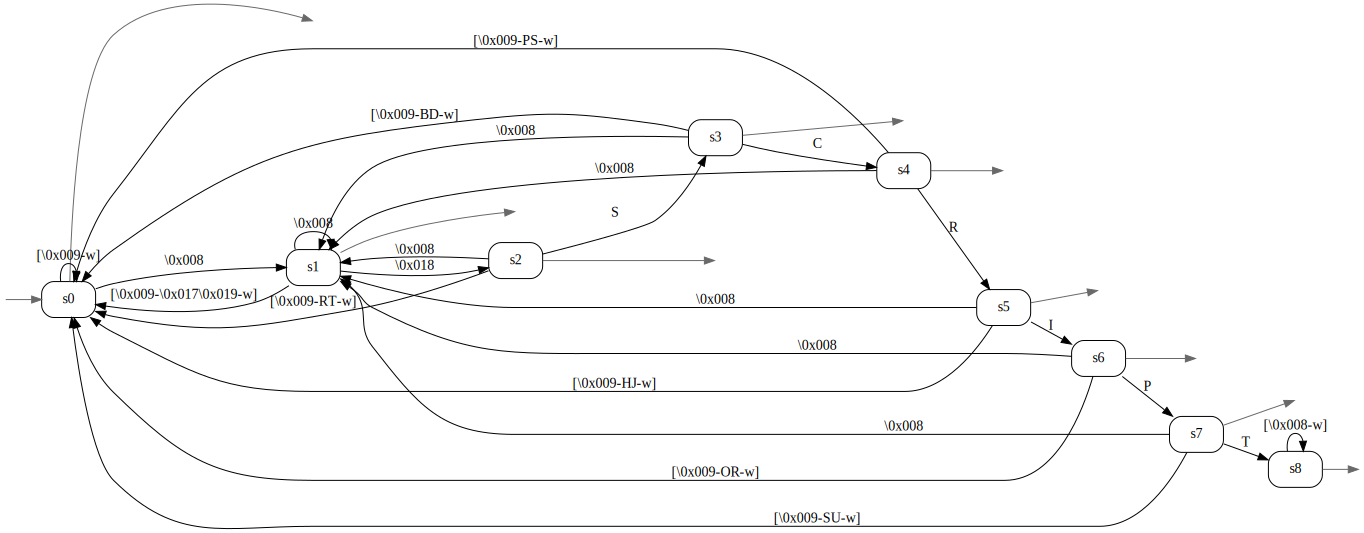

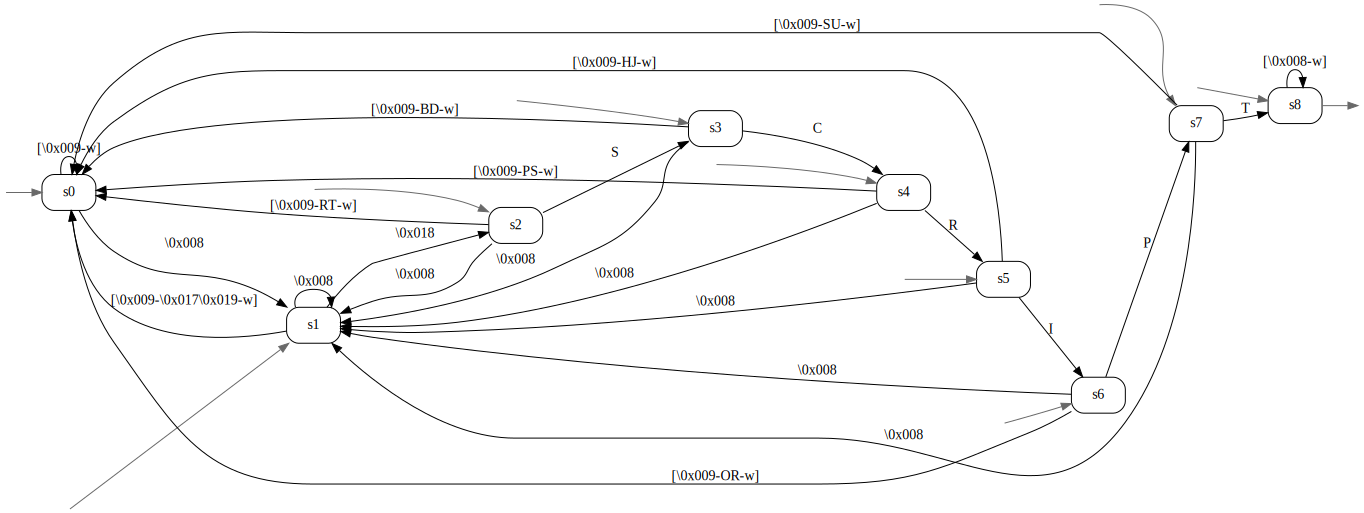

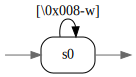

nudle
18


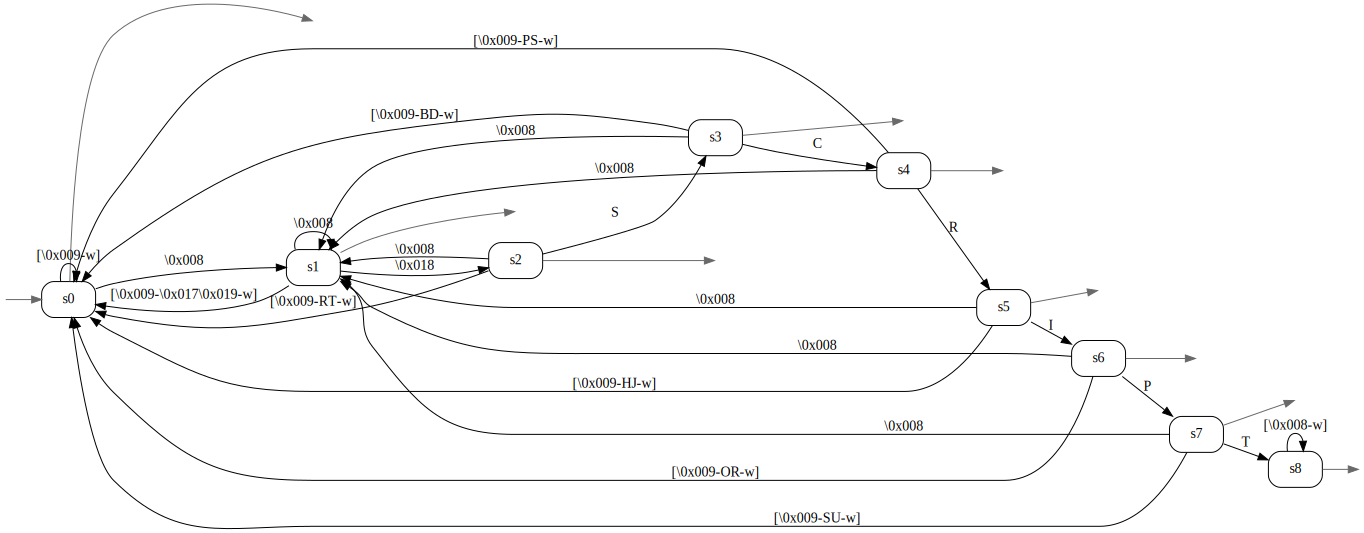

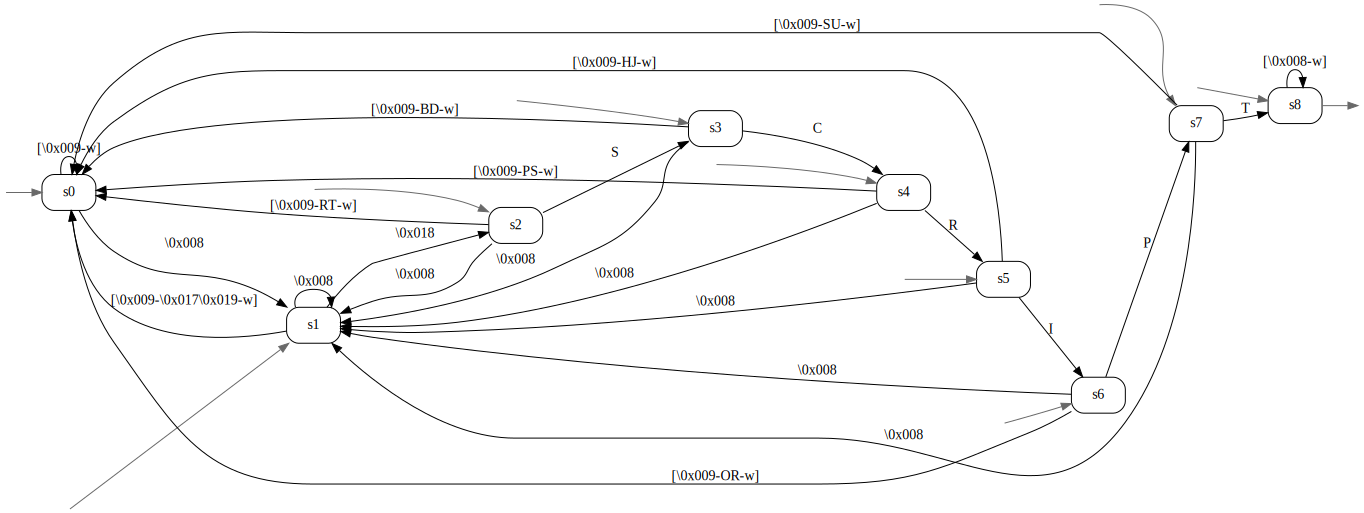

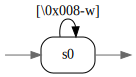

nudle
18


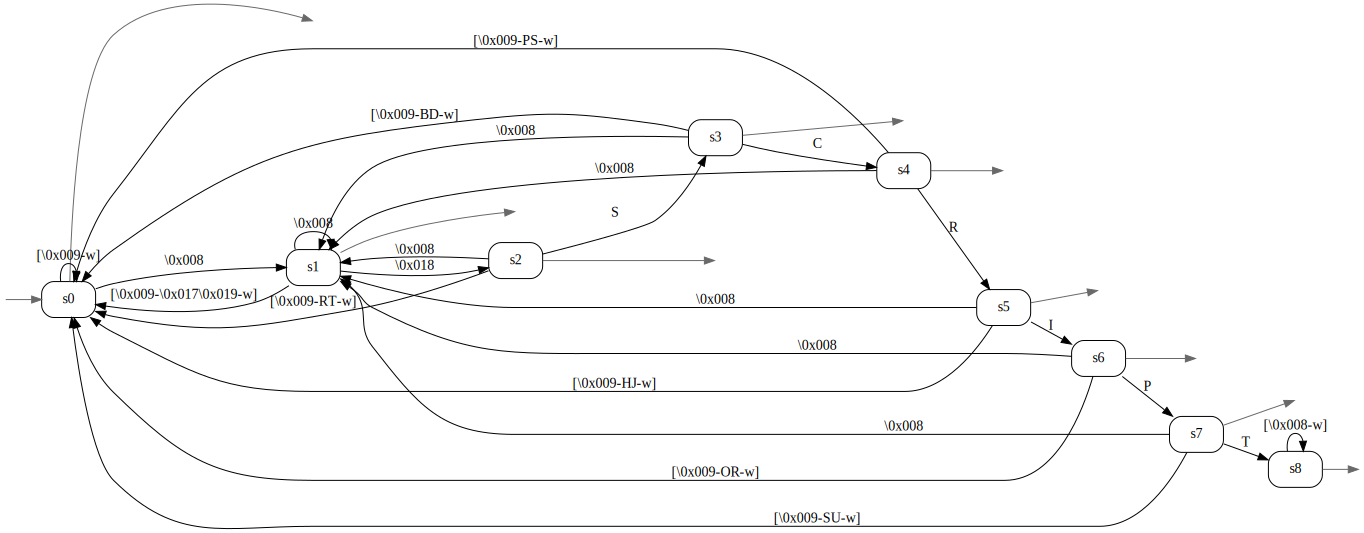

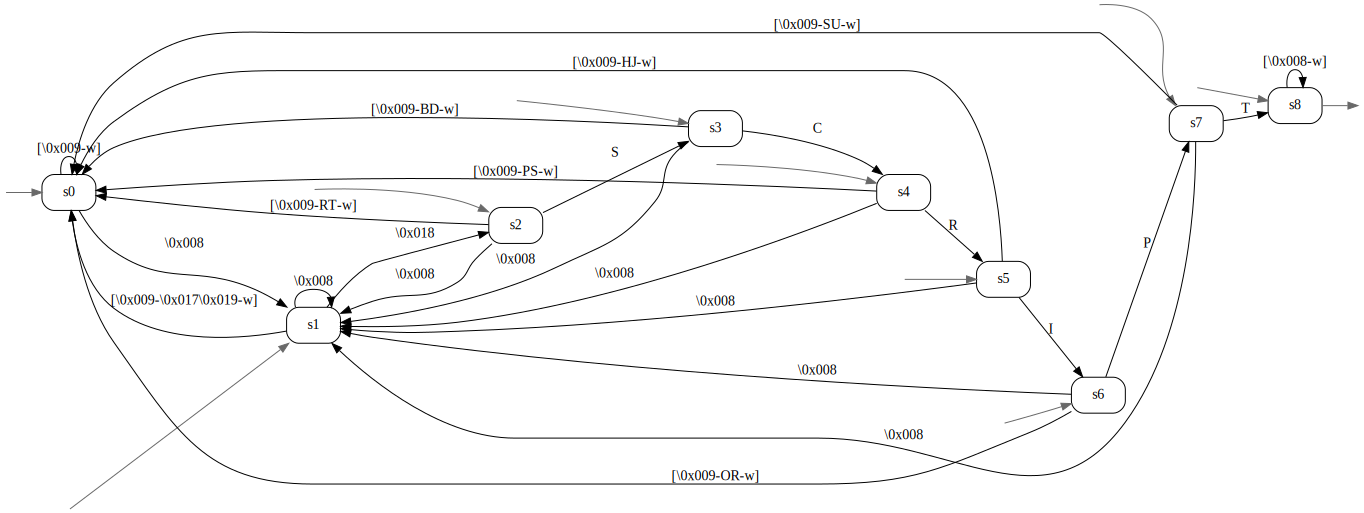

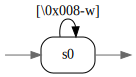

nudle
18


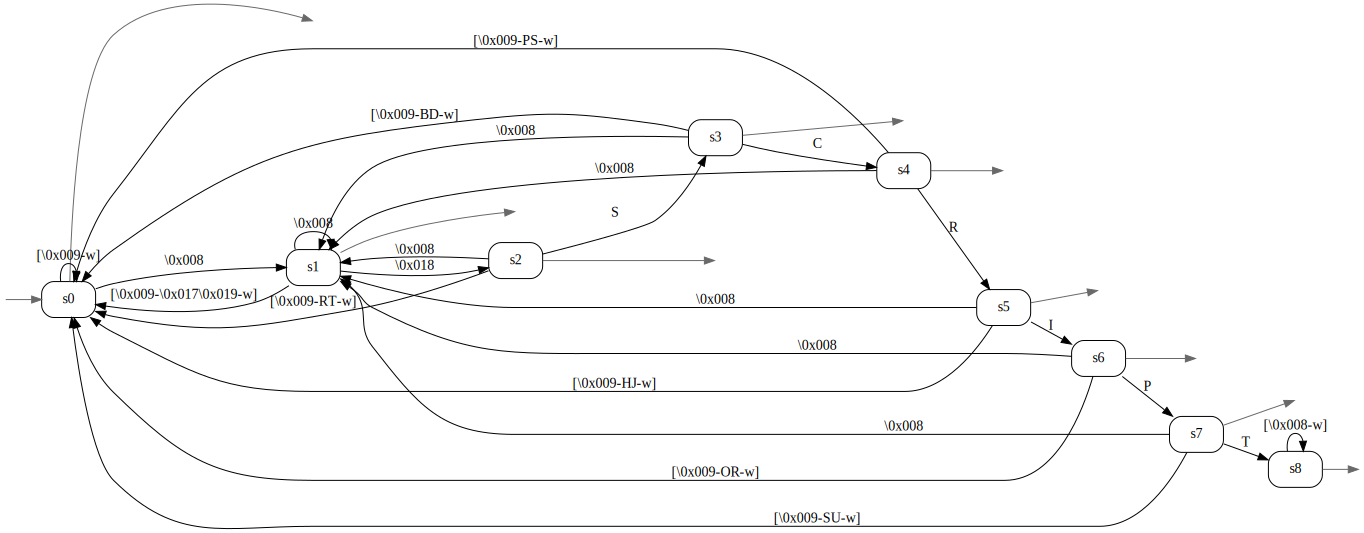

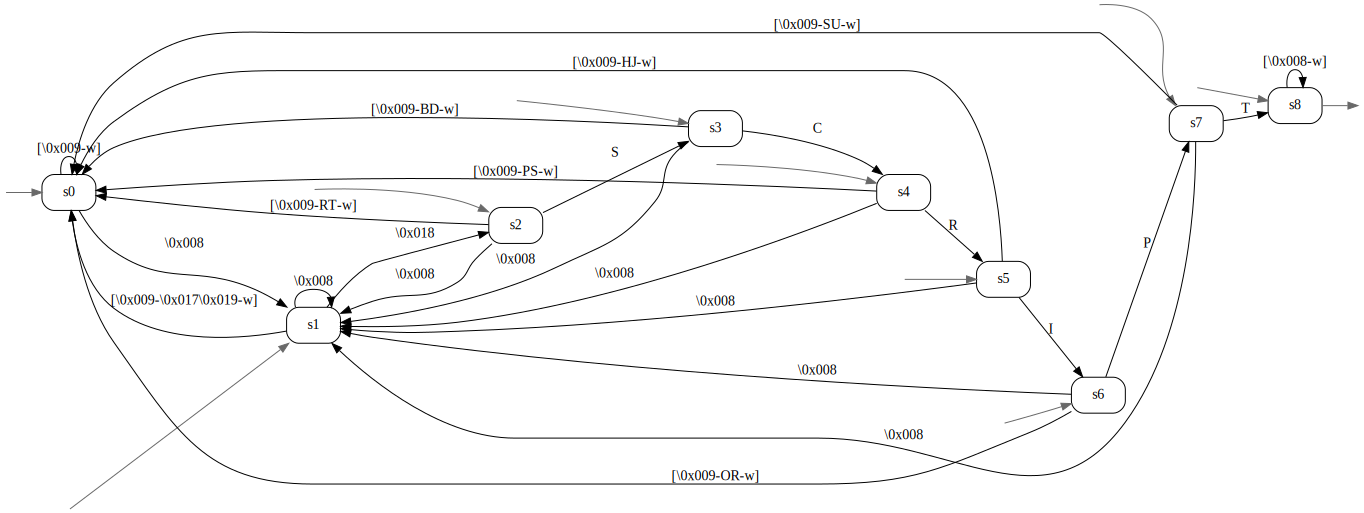

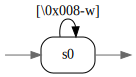

nudle
18


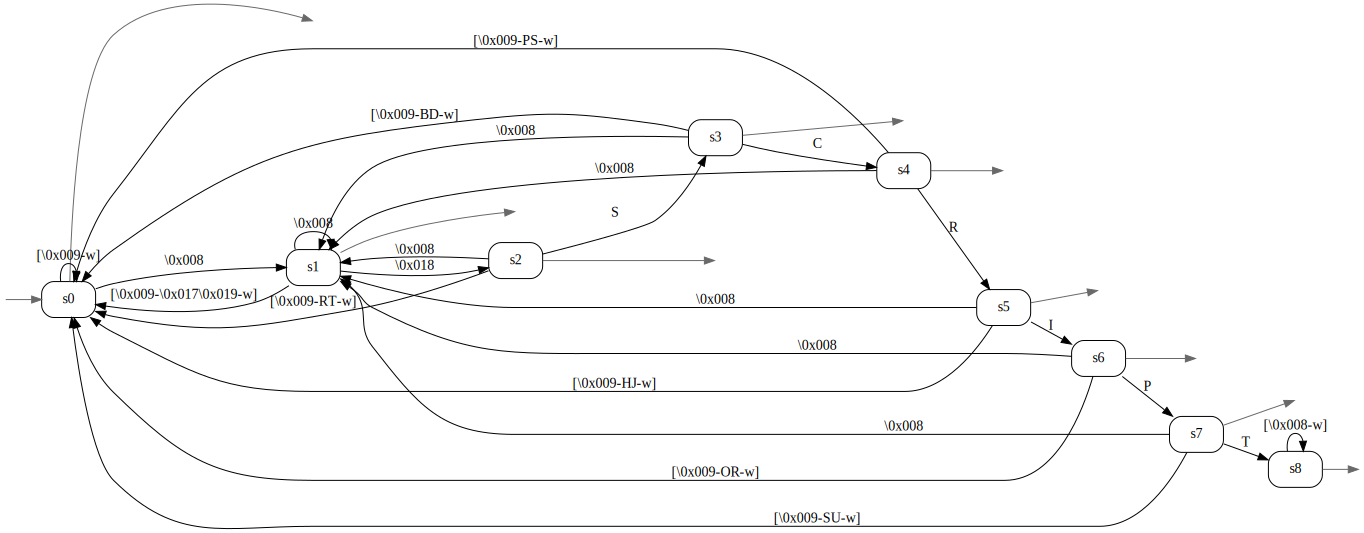

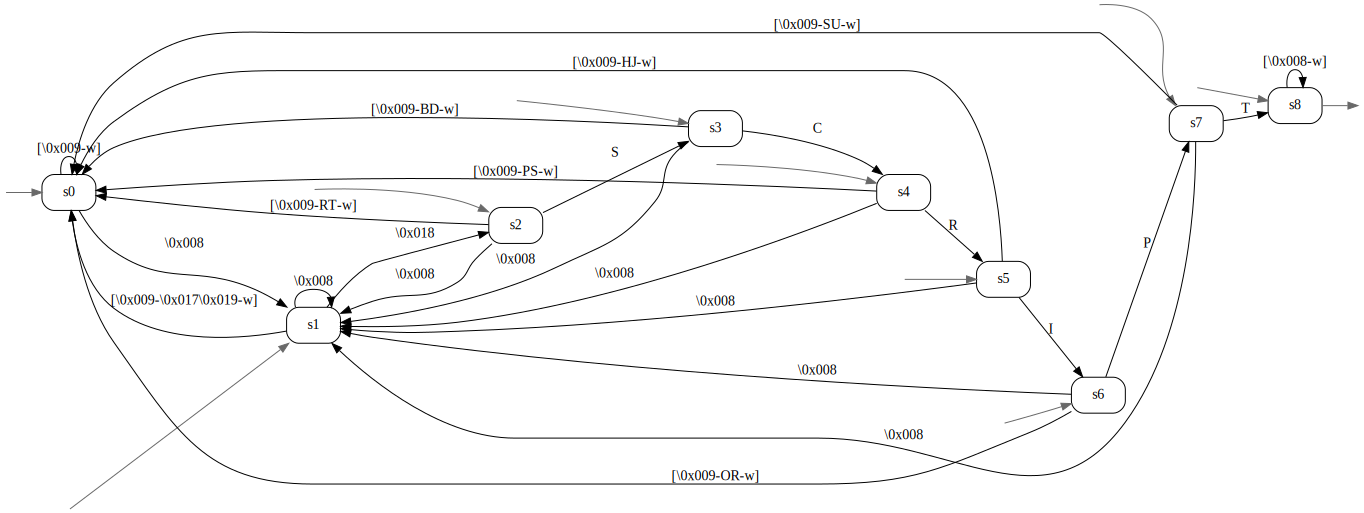

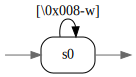

nudle
18


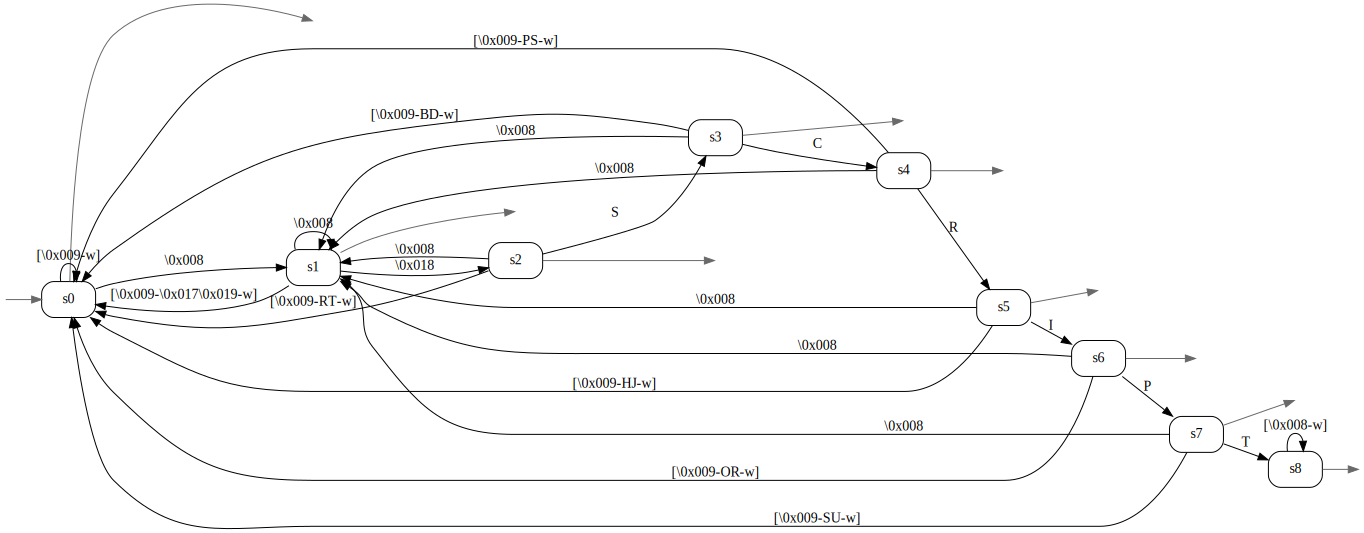

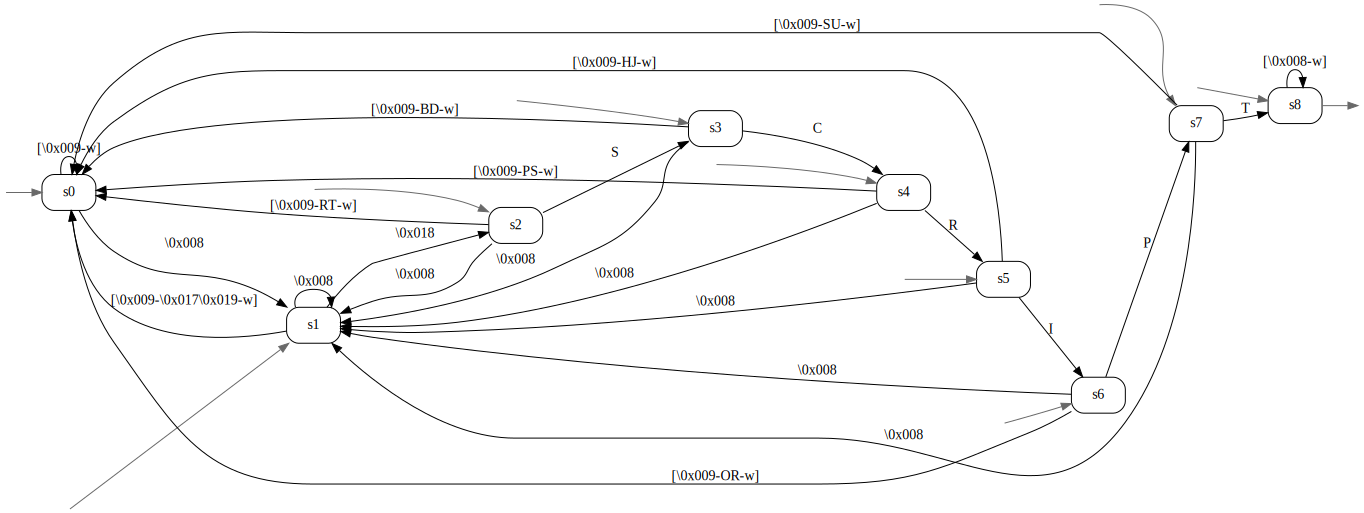

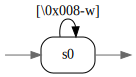

nudle
18


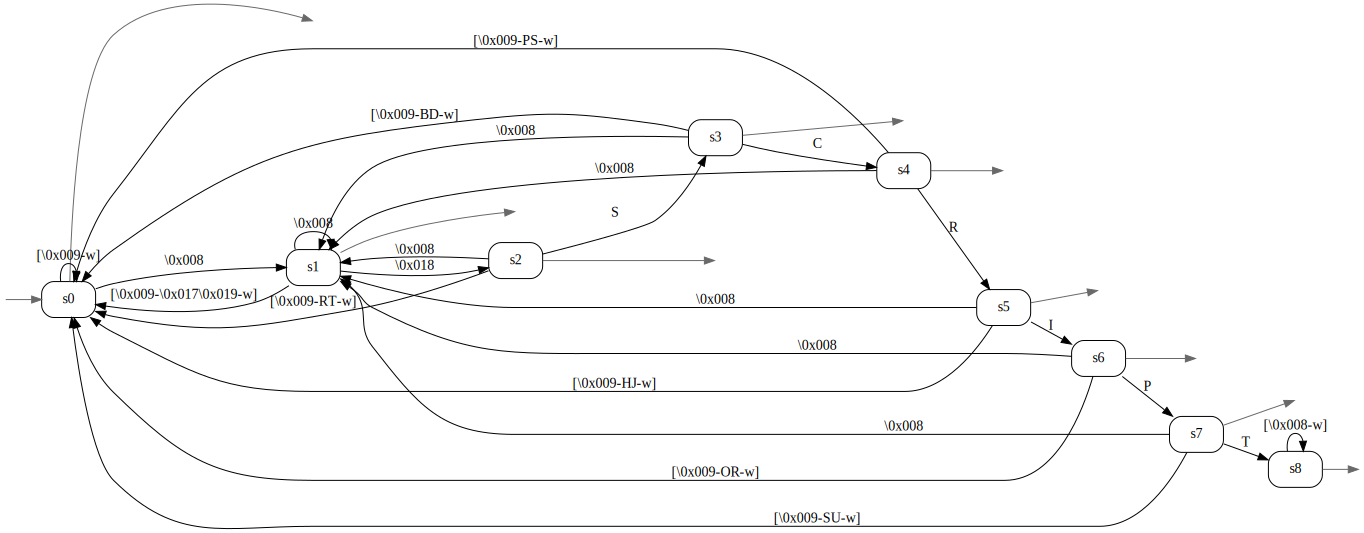

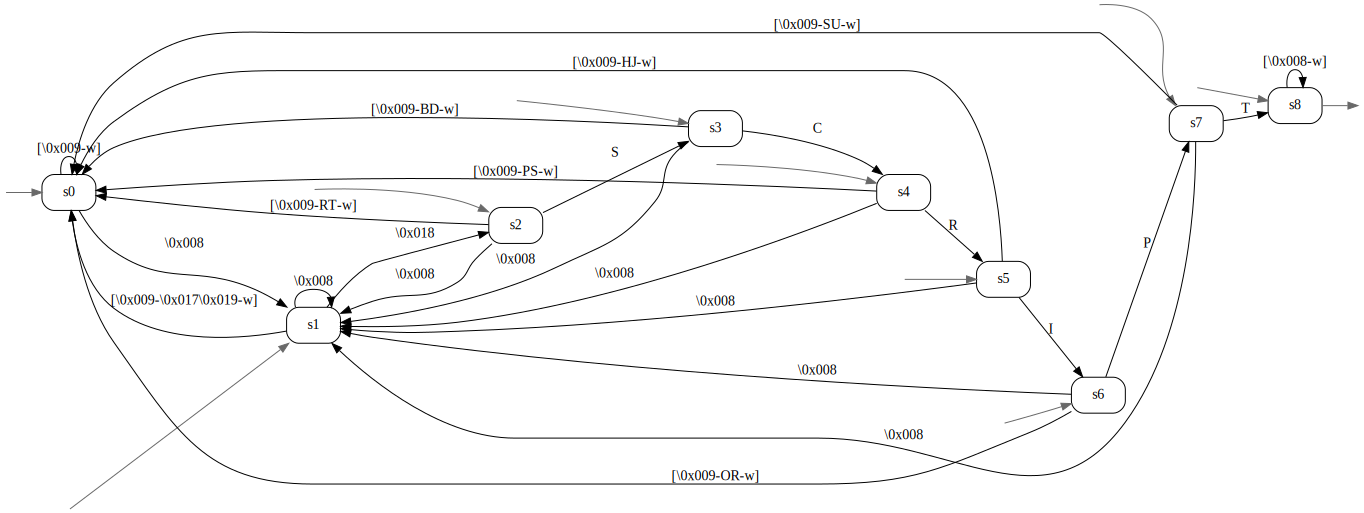

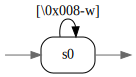

nudle
18


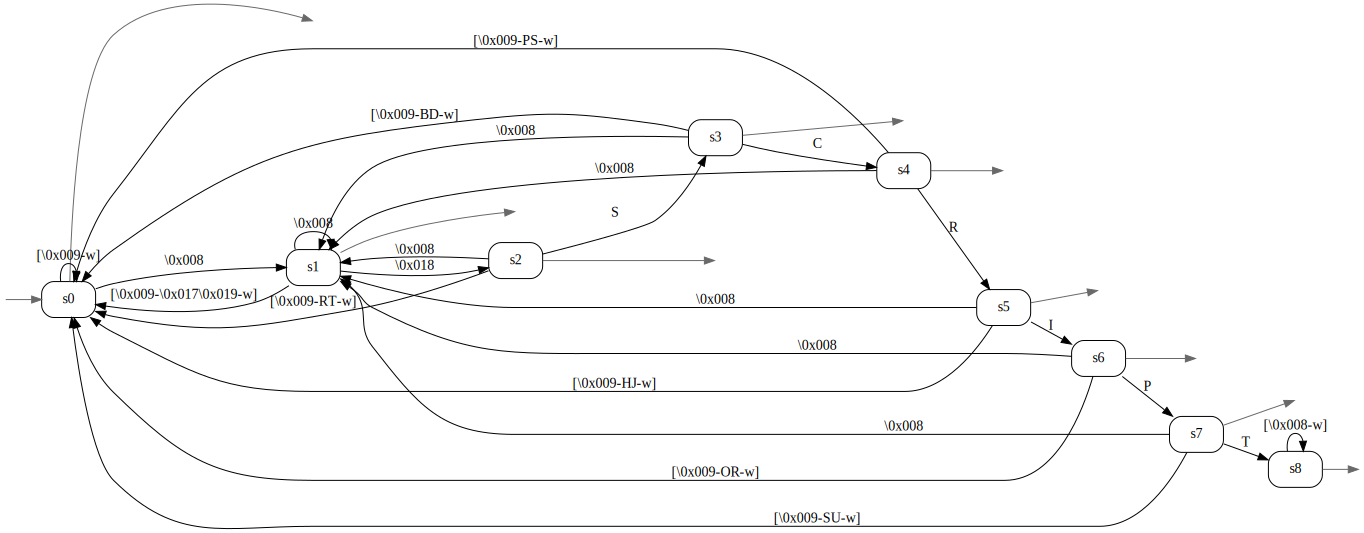

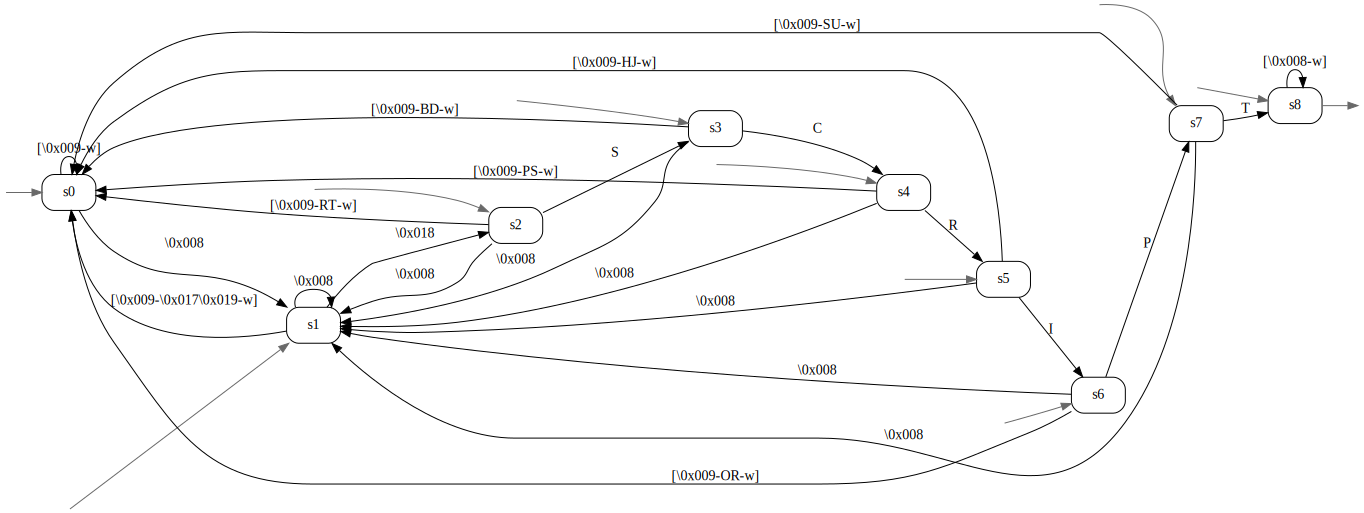

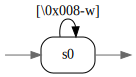

nudle
18


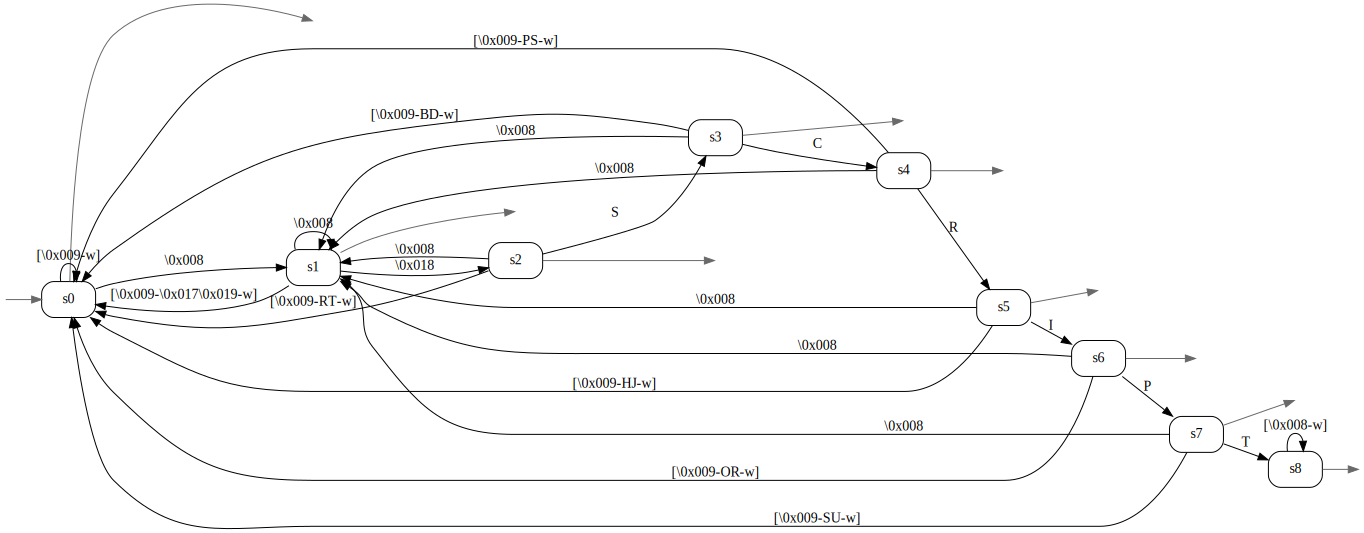

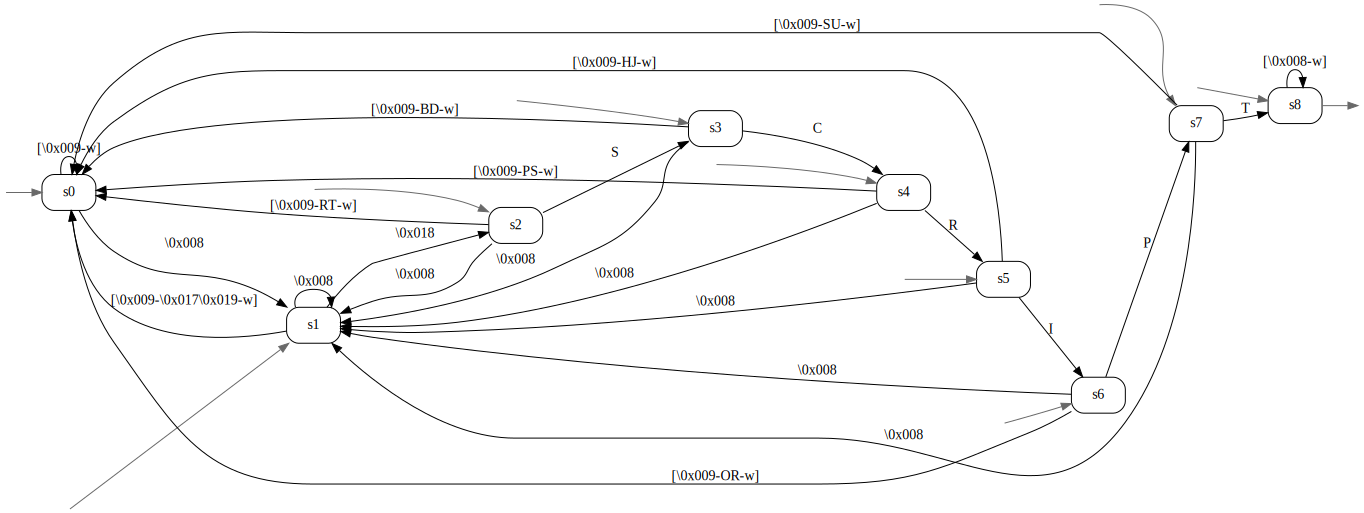

In [39]:
noodle_constraints = []
for noodle in noodles15:
    x37_c_n, x36_c_n = split_segment_aut(noodle)
    constraints = current_constr.copy()
    constraints["x_37"] = constraints["x_37"].product(x37_c_n).minimal_automaton().trim()
    constraints["x_36"] = constraints["x_36"].product(x36_c_n).minimal_automaton().trim()
    noodle_constraints.append(constraints)

    print("nudle")
    product14 = segment_product(query.equations[14], c_)
    print(product14.num_useful_states())
    segments = split_segment_aut(product14)
    #segments = [a.trim() for a in segments]
    show_automata(segments)

0. Propagate x25 from gray path to x37 by fwd
1. Try just manually the graph-based approach + timeit
2. Try de-noodlified approach on x37
3. Propagate x25 into x36 and x37 directly (by substitution)
4. Binary search over noodles?
5. Rewrite the diamond into one equation with long right-hand side and solve it in one pass.